In [3]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


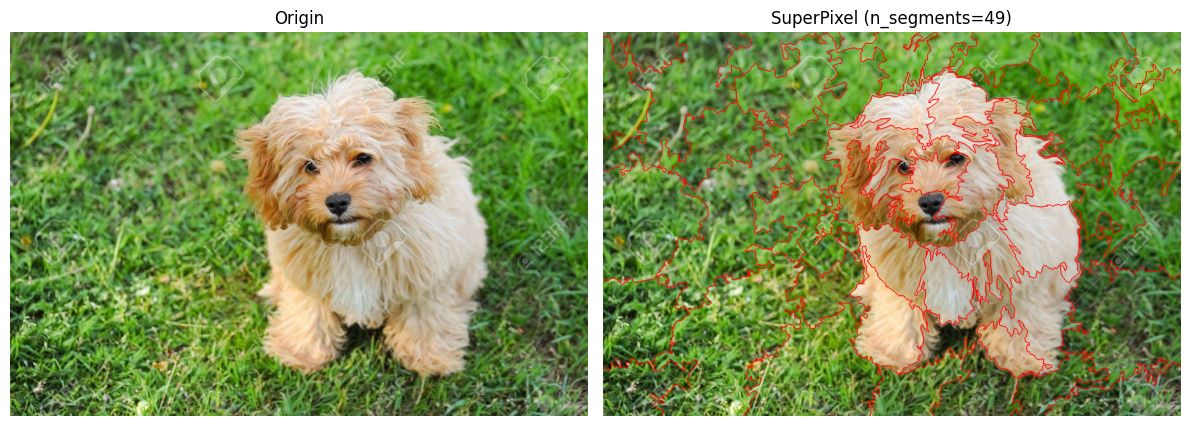

In [ ]:
# 필수 라이브러리 임포트
from skimage import io, segmentation, color
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import numpy as np

# 1. 이미지 로드 및 전처리
# 'your_image.jpg' 부분을 실제 이미지 경로로 변경
image = io.imread(r'/content/drive/MyDrive/FISA_기술세미나/presentation_doc/아주_귀여운_강아지.jpg')
image_float = img_as_float(image)  # [0,1] 범위로 정규화

# 2. SLIC 슈퍼픽셀 분할 수행
segments = segmentation.slic(
    image_float,
    n_segments=100,    # 생성할 슈퍼픽셀 개수
    compactness=10,    # 형태 보존 강도 (높을수록 정사각형에 가까움)
    sigma=1            # 전처리 가우시안 블러 강도
)

# 3. 시각화를 위한 경계선 추출
boundaries = segmentation.mark_boundaries(
    image_float,
    segments,
    color=(1,0,0)      # 경계선 색상 (빨강)
)

# 4. 결과 시각화
plt.figure(figsize=(12, 6))

# 원본 이미지 표시
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Origin')
plt.axis('off')

# 슈퍼픽셀 분할 결과 표시
plt.subplot(1, 2, 2)
plt.imshow(boundaries)
plt.title(f'SuperPixel (n_segments={len(np.unique(segments))})')
plt.axis('off')

plt.tight_layout()
plt.show()

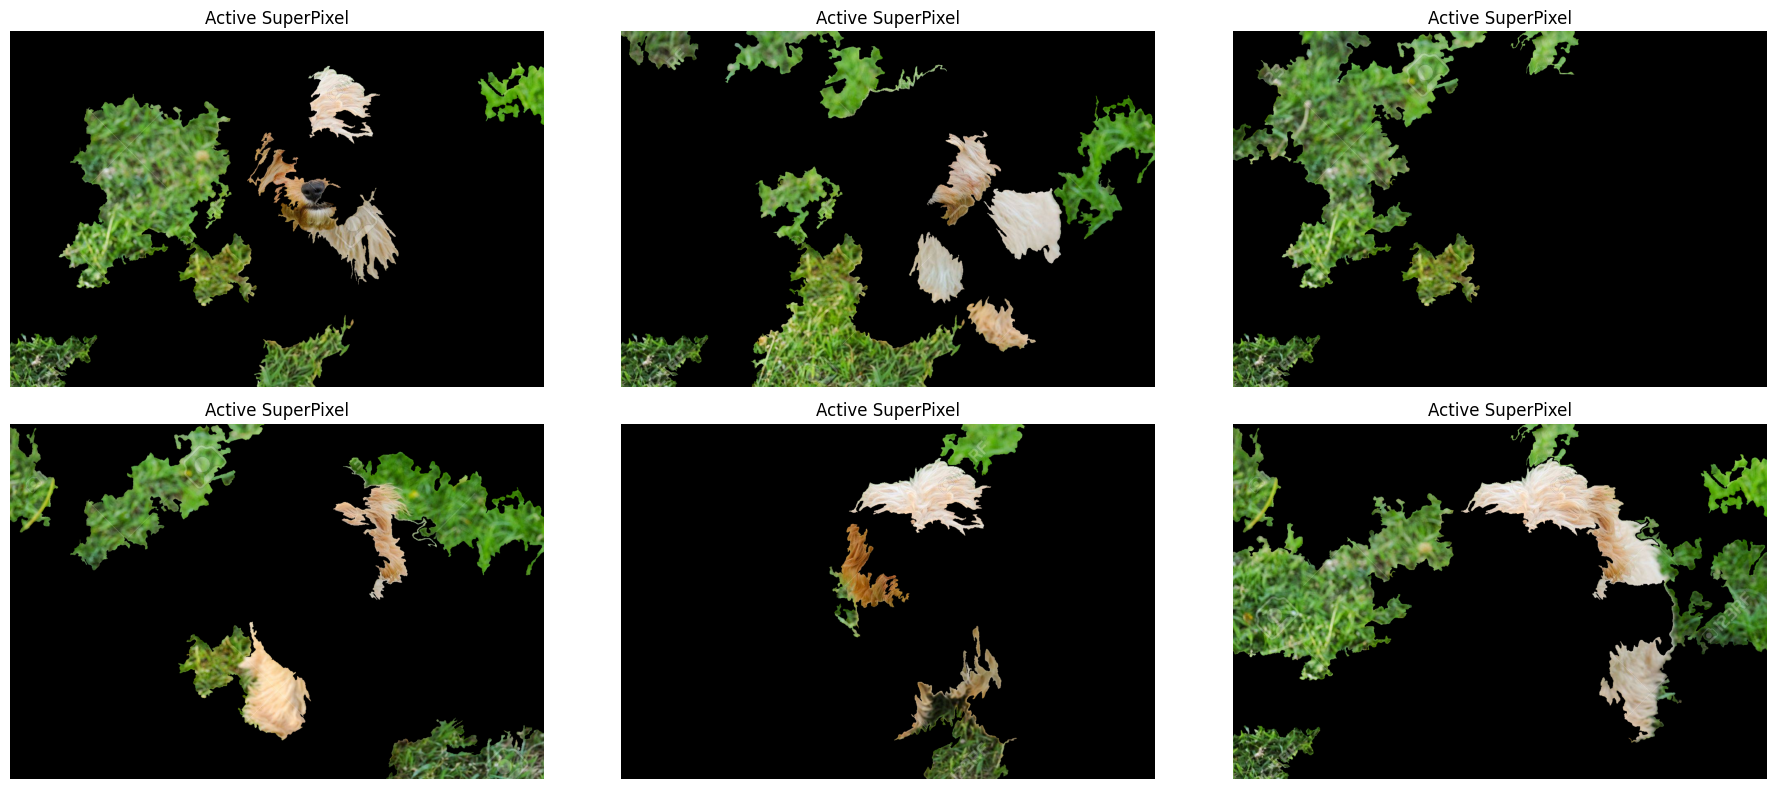

In [ ]:
#  랜덤 선택을 위한 고유 레이블 추출
unique_labels = np.unique(segments)
np.random.seed(42)  # 재현성 보장

# 4. 다중 시각화 생성
plt.figure(figsize=(20, 8))

# 6가지 다른 조합 시각화
for i in range(6):
    # 랜덤 레이블 선택 (5~20개 사이)
    selected = np.random.choice(unique_labels, size=np.random.randint(5, 20), replace=False)

    # 선택 영역 마스크 생성
    mask = np.isin(segments, selected)

    # 선택 영역 강조 이미지 생성
    highlighted = image_float.copy()
    highlighted[~mask] = 0  # 비선택 영역 검정 처리

    # 서브플롯 구성
    plt.subplot(2, 3, i+1)
    plt.imshow(highlighted)
    plt.title(f'Active SuperPixel')
    plt.axis('off')
    plt.tight_layout()

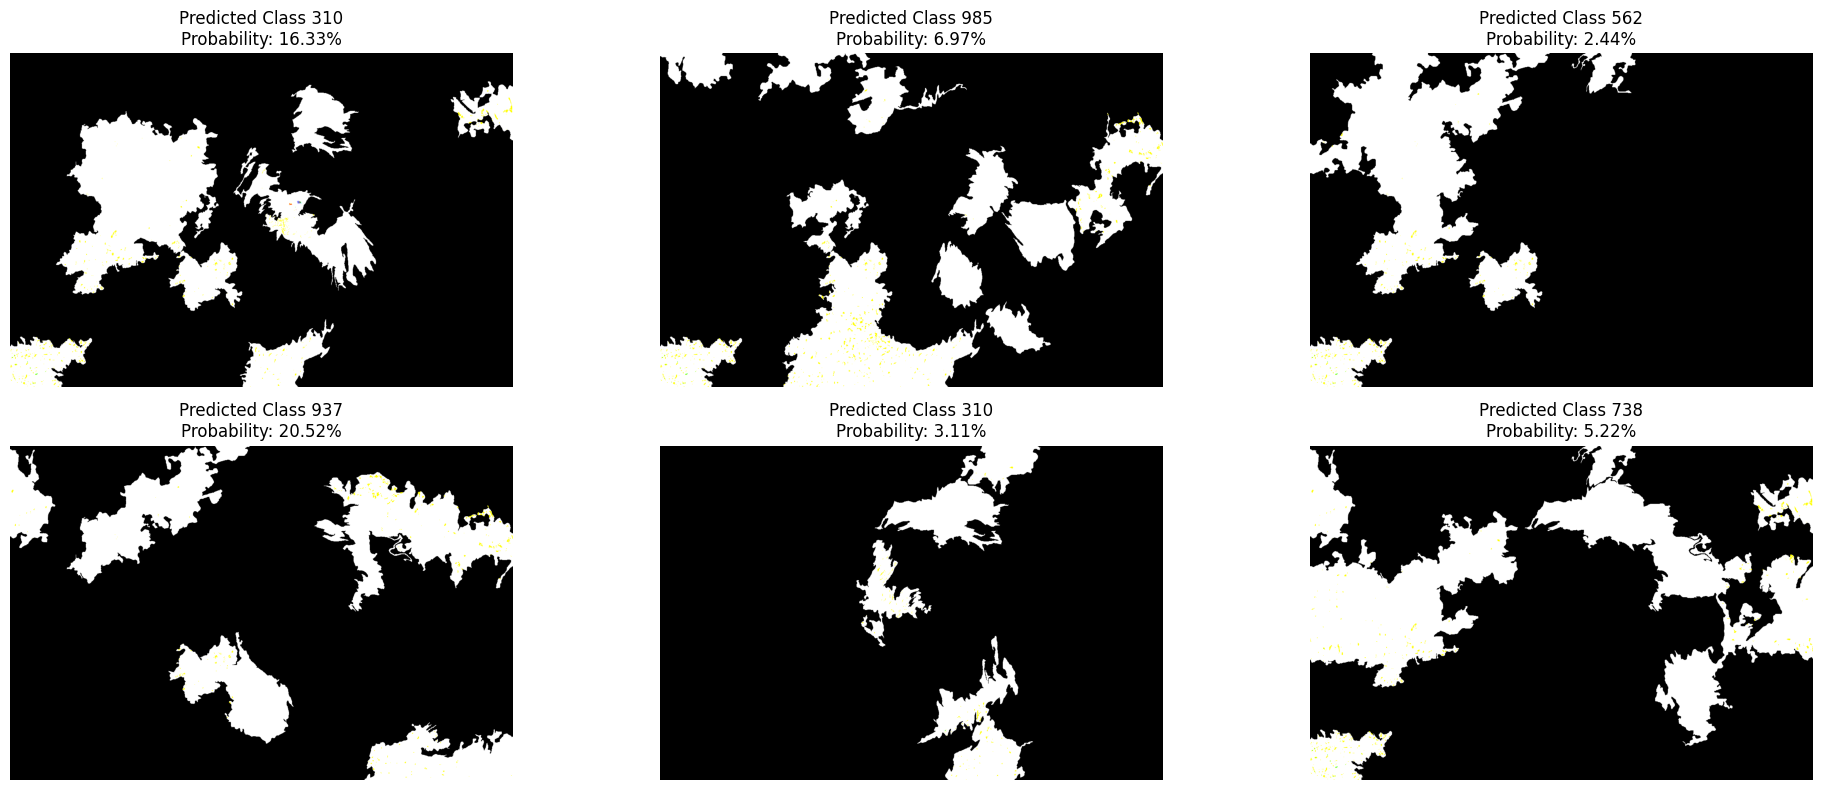

In [ ]:
# 필요한 라이브러리 임포트
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import torch.nn.functional as F
from skimage import io, segmentation, color

# 예시 이미지 로드
image_path = '/content/drive/MyDrive/FISA_기술세미나/presentation_doc/아주_귀여운_강아지.jpg'
image = Image.open(image_path)

# 이미지를 numpy 배열로 변환 (단, float32 형식으로)
image_np = np.array(image).astype(np.float32)

# 이미지가 RGB일 경우, float32로 변환하여 `image_float` 생성
image_float = image_np / 255.0  # 0-1 범위로 정규화

# SLIC 슈퍼픽셀 분할 수행
segments = segmentation.slic(
    image_float,
    n_segments=100,    # 생성할 슈퍼픽셀 개수
    compactness=10,    # 형태 보존 강도 (높을수록 정사각형에 가까움)
    sigma=1            # 전처리 가우시안 블러 강도
)

# 예시로 랜덤으로 선택된 6개의 다른 강조된 이미지를 생성
unique_labels = np.unique(segments)
np.random.seed(42)  # 재현성 보장

# 모델 로드 (미리 학습된 모델 사용)
model = models.resnet18(pretrained=True)
model.eval()  # 평가 모드로 설정

# 이미지 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # 모델 입력 크기로 조정
    transforms.ToTensor(),  # 텐서로 변환
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
])

# 결과 출력 준비
fig, axes = plt.subplots(2, 3, figsize=(20, 8))

# 6가지 다른 조합 시각화
for i in range(6):
    # 랜덤 레이블 선택 (5~20개 사이)
    selected = np.random.choice(unique_labels, size=np.random.randint(5, 20), replace=False)

    # 선택 영역 마스크 생성
    mask = np.isin(segments, selected)

    # 선택 영역 강조 이미지 생성
    highlighted = image_np.copy()
    highlighted[~mask] = 0  # 비선택 영역 검정 처리

    # 강조된 이미지 텐서로 변환
    highlighted_image = Image.fromarray(highlighted.astype(np.uint8))
    image_tensor = transform(highlighted_image).unsqueeze(0)  # 배치 차원 추가

    # 모델 예측
    with torch.no_grad():
        outputs = model(image_tensor)  # 모델 예측
        probabilities = F.softmax(outputs, dim=1)  # 소프트맥스 적용
        top_prob, top_class = torch.topk(probabilities, 1)  # 가장 높은 확률의 클래스

    # 예측 결과 출력
    class_idx = top_class.item()
    prob = top_prob.item() * 100

    # 이미지 범위 0-255로 클리핑하여 표시
    highlighted = np.clip(highlighted, 0, 255)  # 클리핑 처리

    axes[i//3, i%3].imshow(highlighted)
    axes[i//3, i%3].axis('off')
    axes[i//3, i%3].set_title(f"Predicted Class {class_idx}\nProbability: {prob:.2f}%")

plt.tight_layout()
plt.show()

In [7]:
!pip install lime/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=dd7a7d07796896c40e9f63e295de209b878df2e95c9017044cfd44a051cff4de
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


  0%|          | 0/10 [00:00<?, ?it/s]

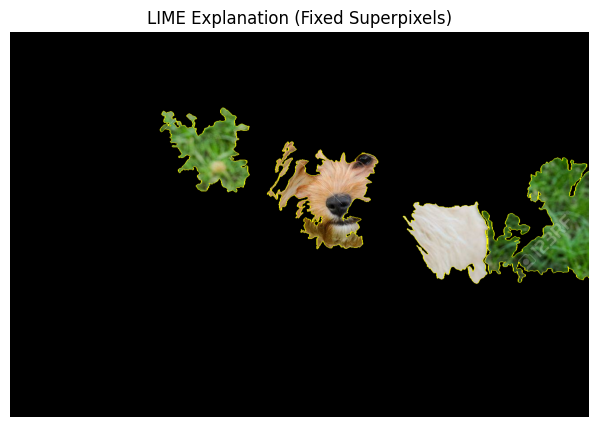

In [14]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torchvision import models, transforms
from PIL import Image
import torch.nn.functional as F
from skimage import segmentation
from lime import lime_image
from skimage.segmentation import mark_boundaries

# 이미지 로드 및 전처리
def load_image(image_path):
    image = Image.open(image_path).convert("RGB")  # RGB 변환 추가
    image_np = np.array(image).astype(np.float32) / 255.0  # 정규화
    return image, image_np

# 모델 로드 및 전처리 변환 설정
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
model.eval()
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def predict(image_np):
    # 배치 차원이 존재할 경우 처리
    if image_np.ndim == 4:
        predictions = []
        for i in range(image_np.shape[0]):
            img = (image_np[i] * 255).astype(np.uint8)
            img_pil = Image.fromarray(img)
            img_tensor = transform(img_pil).unsqueeze(0)

            with torch.no_grad():
                outputs = model(img_tensor)
                probabilities = F.softmax(outputs, dim=1).cpu().numpy()

            predictions.append(probabilities)

        return np.vstack(predictions)  # 여러 개의 예측을 배열로 반환

    else:  # 단일 이미지 처리
        img = (image_np * 255).astype(np.uint8)
        img_pil = Image.fromarray(img)
        img_tensor = transform(img_pil).unsqueeze(0)

        with torch.no_grad():
            outputs = model(img_tensor)
            probabilities = F.softmax(outputs, dim=1).cpu().numpy()

        return probabilities

# 동일한 슈퍼픽셀 분할 수행
def generate_superpixels(image_np, n_segments=100, compactness=10, sigma=1):
    return segmentation.slic(image_np, n_segments=n_segments, compactness=compactness, sigma=sigma)

# LIME 기반 설명 생성 및 시각화 (슈퍼픽셀 고정)
def lime_explanation(image_np, segments):
    explainer = lime_image.LimeImageExplainer()
    explanation = explainer.explain_instance(
        image_np,
        predict,
        top_labels=10,
        hide_color=0,
        num_samples=10,
        segmentation_fn=lambda x: segments  # 우리가 만든 segments 사용
    )

    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0], positive_only=True, hide_rest=True
    )

    plt.figure(figsize=(10, 5))
    plt.imshow(mark_boundaries(temp, mask))
    plt.title("LIME Explanation (Fixed Superpixels)")
    plt.axis('off')
    plt.show()

# 실행 코드
image_path = r'/content/drive/MyDrive/FISA_기술세미나/presentation_doc/아주_귀여운_강아지.jpg'
image, image_np = load_image(image_path)

# 동일한 슈퍼픽셀 생성
segments = generate_superpixels(image_np)

# 동일한 슈퍼픽셀을 사용한 LIME 설명
lime_explanation(image_np, segments)